In [21]:
import sys
import warnings
import time
import copy
import json
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import cvxpy as cp

from pyepo.model.opt import optModel
sys.path.insert(0, '/Users/dennis/Downloads/2024-fall/research/Fairness-Decision-Focused-Loss/The Paper/algorithm')
from myutil import *
from features import get_all_features

# Suppress warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


### Import and Process Data

In [22]:
alpha, Q = 2, 200

In [23]:
def d_func_continuous(y1, y2):
    # For real-valued normalized targets
    return torch.exp(-(y1 - y2).pow(2))

In [24]:
df = pd.read_csv('data/data.csv')
df = df.sample(n=1000, random_state=1)

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)

risk = df['risk_score_t'].values
risk = risk + 0.001 if 0 in risk else risk

feats = df[get_all_features(df)].values
gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.random.normal(1, 0.5, len(risk)).clip(0.1, 2)
race = df['race'].values

scaler = StandardScaler()
feats = scaler.fit_transform(feats)

In [25]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            # First layer with batch normalization
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output layer
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x).squeeze(-1)

class FairMSELoss(nn.Module):
    def __init__(self, lambda_fairness=1.0):
        super(FairMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_fairness = lambda_fairness

    def forward(self, pred, target, race):
        mse_loss = self.mse(pred, target)
        group_means = [pred[race == g].mean() if (race == g).sum() > 0 else 0 for g in [0, 1]]
        fairness_loss = torch.abs(group_means[0] - group_means[1])
        return mse_loss + self.lambda_fairness * fairness_loss


In [26]:
def regret(predmodel, optmodel, dataloader, alpha=alpha, Q=Q):
    predmodel.eval()
    feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(dataloader))

    if torch.cuda.is_available():
        feats, risk, gainF, cost, race, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), race.cuda(), opt_sol.cuda(), opt_val.cuda()

    with torch.no_grad():
        pred_risk = predmodel(feats)

    risk = risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.detach().to('cpu').numpy().flatten()
    pred_risk = pred_risk.clip(min=0.001)
    gainF = gainF.detach().to('cpu').numpy().flatten()
    cost = cost.detach().to('cpu').numpy().flatten()
    pred_sol, _ = optmodel(gainF, pred_risk, cost, alpha, Q)
        
    pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)

    normalized_regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)
    predmodel.train()
    return normalized_regret

## Fairness Measures

% Individual Fairness (f_1) in Fair Regression
\begin{align*}
f_{1}(w) &= \frac{1}{n_{0}n_{1}} \sum_{i \in G_{0}} \sum_{j \in G_{1}} d(y_i, y_j)\,\Bigl( w\cdot x_i - w\cdot x_j \Bigr)^2, \\
\frac{\partial f_{1}(w)}{\partial w} &= \frac{2}{n_{0}n_{1}} \sum_{i \in G_{0}} \sum_{j \in G_{1}} d(y_i, y_j)\,\Bigl( w\cdot x_i - w\cdot x_j \Bigr)\,\Bigl( x_i - x_j \Bigr).
\end{align*}

% Group Fairness (f_2) in Fair Regression
\begin{align*}
f_{2}(w) &= \left( \frac{1}{n_{0}n_{1}} \sum_{i \in G_{0}} \sum_{j \in G_{1}} d(y_i, y_j)\,\Bigl( w\cdot x_i - w\cdot x_j \Bigr) \right)^2, \\
\frac{\partial f_{2}(w)}{\partial w} &= \frac{2}{n_{0}n_{1}} \left( \sum_{i \in G_{0}} \sum_{j \in G_{1}} d(y_i, y_j)\,\Bigl( w\cdot x_i - w\cdot x_j \Bigr) \right)
\left( \sum_{i \in G_{0}} \sum_{j \in G_{1}} d(y_i, y_j)\,\Bigl( x_i - x_j \Bigr) \right).
\end{align*}


% Atkinson's Inequality Index and Gradient
\begin{align*}
b_i &= \bigl(\hat{y}_i - y_i\bigr)^2, \quad \mu = \frac{1}{n} \sum_{i=1}^{n} b_i, \\
\text{for } \beta \neq 1:\quad A_\beta &= 1 - \frac{1}{\mu} \left( \frac{1}{n} \sum_{i=1}^{n} b_i^{\,1-\beta} \right)^{\frac{1}{\,1-\beta}}, \\
\text{for } \beta = 1:\quad A_1 &= 1 - \frac{1}{\mu} \left( \prod_{i=1}^{n} b_i \right)^{\frac{1}{n}}.
\end{align*}
The gradient for the $k$ th element (assuming $\beta \neq 1$) is:
\begin{align*}
\frac{\partial A_\beta}{\partial \hat{y}_k} &= -\frac{2(\hat{y}_k - y_k)}{n} \left[ \frac{U^{\frac{\beta}{\,1-\beta}}}{(1-\beta)\,\mu}\,b_k^{-\beta} - \frac{U^{\frac{1}{1-\beta}}}{\mu^2} \right], \\
\text{with} \quad U &= \frac{1}{n}\sum_{i=1}^{n} b_i^{\,1-\beta}.
\end{align*}

% Bounded Statistical Parity and Gradient
\begin{align*}
\overline{\hat{y}}_0 &= \frac{1}{n_0}\sum_{i \in G_0}\hat{y}_i, \quad \overline{\hat{y}}_1 = \frac{1}{n_1}\sum_{j \in G_1}\hat{y}_j, \\
\overline{y}_0 &= \frac{1}{n_0}\sum_{i \in G_0}y_i, \quad \overline{y}_1 = \frac{1}{n_1}\sum_{j \in G_1}y_j, \\
f_{\text{SP}} &= \max\Bigl\{0,\; |\overline{\hat{y}}_0-\overline{\hat{y}}_1| - \Bigl(|\overline{y}_0-\overline{y}_1|+\varepsilon\Bigr) \Bigr\}.
\end{align*}
If 
$$|\overline{\hat{y}}_0-\overline{\hat{y}}_1| > |\overline{y}_0-\overline{y}_1|+\varepsilon,$$
then the gradients are:
\begin{align*}
\frac{\partial f_{\text{SP}}}{\partial \hat{y}_i} &= \frac{\operatorname{sgn}(\overline{\hat{y}}_0 - \overline{\hat{y}}_1)}{n_0},\quad i \in G_0,\\[1mm]
\frac{\partial f_{\text{SP}}}{\partial \hat{y}_j} &= -\frac{\operatorname{sgn}(\overline{\hat{y}}_0 - \overline{\hat{y}}_1)}{n_1},\quad j \in G_1.
\end{align*}
If the penalty is zero, the gradients are zero.


In [27]:
import torch

def compute_fairness_value(pred, true, race, fairness_measure, epsilon=1e-6, d_func=None, beta=0.5):
    """
    Compute the fairness penalty value based on the selected fairness_measure.
    Parameters:
      pred: Tensor of predictions (1D, shape: [n])
      true: Tensor of true values (1D, shape: [n])
      race: Tensor of group indicators (1D, same shape)
      fairness_measure: one of "individual", "group", "atkinson", "stat_parity", "accuracy_parity"
      epsilon: extra allowed margin for stat_parity
      d_func: weighting function for "individual" or "group" (if None, use default exponential)
      beta: parameter used in the Atkinson index
    Returns:
      fairness_value: a scalar torch tensor.
    """
    if d_func is None:
        # Default: for continuous (normalized) targets.
        d_func = lambda y1, y2: torch.exp(-(y1 - y2).pow(2))
    
    n = pred.numel()
    
    if fairness_measure == "individual":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        if n0 == 0 or n1 == 0:
            return torch.tensor(0.0, device=pred.device)
        pred0 = pred[mask0]
        pred1 = pred[mask1]
        true0 = true[mask0]
        true1 = true[mask1]
        diff = pred0.unsqueeze(1) - pred1.unsqueeze(0)
        D = d_func(true0.unsqueeze(1), true1.unsqueeze(0))
        f1 = (D * diff.pow(2)).sum() / (n0 * n1)
        return f1


    elif fairness_measure == "group":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        if n0 == 0 or n1 == 0:
            return torch.tensor(0.0, device=pred.device)
        pred0 = pred[mask0]
        pred1 = pred[mask1]
        true0 = true[mask0]
        true1 = true[mask1]
        diff = pred0.unsqueeze(1) - pred1.unsqueeze(0)
        D = d_func(true0.unsqueeze(1), true1.unsqueeze(0))
        sum_term = (D * diff).sum() / (n0 * n1)
        f2 = sum_term.pow(2)
        return f2

    elif fairness_measure == "atkinson":
        # Use b_i = (pred - true)^2 (must be > 0)
        b = (pred - true).pow(2).clamp_min(1e-12)
        mu = b.mean()
        U = b.pow(1.0 - beta).mean()
        if abs(beta - 1.0) > 1e-8:
            term = U.pow(1.0 / (1.0 - beta))
        else:
            term = torch.exp(torch.log(b).mean())
        A = 1.0 - term / mu
        return A

    elif fairness_measure == "stat_parity":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        if n0 == 0 or n1 == 0:
            return torch.tensor(0.0, device=pred.device)
        mean_pred0 = pred[mask0].mean()
        mean_pred1 = pred[mask1].mean()
        mean_true0 = true[mask0].mean()
        mean_true1 = true[mask1].mean()
        pred_diff = torch.abs(mean_pred0 - mean_pred1)
        data_diff = torch.abs(mean_true0 - mean_true1)
        bound = data_diff + epsilon
        penalty = torch.relu(pred_diff - bound)
        return penalty

    elif fairness_measure == "accuracy_parity":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        if n0 == 0 or n1 == 0:
            return torch.tensor(0.0, device=pred.device)
        mse0 = ((pred[mask0] - true[mask0]).pow(2)).mean()
        mse1 = ((pred[mask1] - true[mask1]).pow(2)).mean()
        f_acc = torch.abs(mse0 - mse1)
        return f_acc

    else:
        return torch.tensor(0.0, device=pred.device)


### Fairness grads

In [28]:
def compute_fairness_grad(pred, true, race, fairness_measure, epsilon=0.0, d_func=None, beta=0.5):
    """
    Compute the gradient of the fairness penalty (d(fairness_value)/d(pred)).
    Parameters:
      pred: Tensor of predictions (1D, shape: [n])
      true: Tensor of true values (1D, shape: [n])
      race: Tensor of group indicators (1D, shape: [n])
      fairness_measure: one of "individual", "group", "atkinson", "stat_parity", "accuracy_parity"
      epsilon: used for stat_parity
      d_func: weighting function (if None, use default exponential)
      beta: parameter used in the Atkinson index case.
    Returns:
      grad_fair: Tensor of same shape as pred representing the fairness gradient.
    """
    if d_func is None:
        d_func = lambda y1, y2: torch.exp(-(y1 - y2).pow(2))
    
    n = pred.numel()
    grad_fair = torch.zeros_like(pred)
    
    if fairness_measure == "individual":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        grad = torch.zeros_like(pred)
        if n0 == 0 or n1 == 0:
            return grad
        pred0 = pred[mask0]
        pred1 = pred[mask1]
        true0 = true[mask0]
        true1 = true[mask1]
        diff = pred0.unsqueeze(1) - pred1.unsqueeze(0)
        D = d_func(true0.unsqueeze(1), true1.unsqueeze(0))
        grad0 = 2 * (D * diff).sum(dim=1) / (n0 * n1)
        grad1 = -2 * (D * diff).sum(dim=0) / (n0 * n1)
        grad[mask0] = grad0
        grad[mask1] = grad1
        return grad

    elif fairness_measure == "group":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        grad = torch.zeros_like(pred)
        if n0 == 0 or n1 == 0:
            return grad
        pred0 = pred[mask0]
        pred1 = pred[mask1]
        true0 = true[mask0]
        true1 = true[mask1]
        diff = pred0.unsqueeze(1) - pred1.unsqueeze(0)
        D = d_func(true0.unsqueeze(1), true1.unsqueeze(0))
        sum_term = (D * diff).sum() / (n0 * n1)
        grad0 = 2 * sum_term * (D.sum(dim=1)) / (n0 * n1)
        grad1 = -2 * sum_term * (D.sum(dim=0)) / (n0 * n1)
        grad[mask0] = grad0
        grad[mask1] = grad1
        return grad

    elif fairness_measure == "atkinson":
        b = (pred - true).pow(2).clamp_min(1e-12)
        mu = b.mean()
        U = b.pow(1.0 - beta).mean()
        if abs(beta - 1.0) > 1e-8:
            term = U.pow(1.0 / (1.0 - beta))
        else:
            term = torch.exp(torch.log(b).mean())
        # Derived gradient: 
        grad_fair = -2 * (pred - true) / n * ( U.pow(beta/(1.0-beta))/(1.0-beta)/ mu * b.pow(-beta) - term/(mu**2) )
        return grad_fair

    elif fairness_measure == "stat_parity":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        if n0 == 0 or n1 == 0:
            return grad_fair
        mean_pred0 = pred[mask0].mean()
        mean_pred1 = pred[mask1].mean()
        mean_true0 = true[mask0].mean()
        mean_true1 = true[mask1].mean()
        pred_diff = torch.abs(mean_pred0 - mean_pred1)
        data_diff = torch.abs(mean_true0 - mean_true1)
        bound = data_diff + epsilon
        penalty = pred_diff - bound
        if penalty > 0:
            sign_val = torch.sign(mean_pred0 - mean_pred1)
            grad_fair[mask0] = sign_val / n0
            grad_fair[mask1] = -sign_val / n1
        else:
            grad_fair.zero_()
        return grad_fair

    elif fairness_measure == "accuracy_parity":
        mask0 = (race == 0)
        mask1 = (race == 1)
        n0 = mask0.sum().item()
        n1 = mask1.sum().item()
        if n0 == 0 or n1 == 0:
            return grad_fair
        grad = torch.zeros_like(pred)
        grad[mask0] = 2 * (pred[mask0] - true[mask0]) / n0
        grad[mask1] = -2 * (pred[mask1] - true[mask1]) / n1
        return grad

    else:
        return grad_fair


In [29]:
# Write a small test case
print(compute_fairness_value(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "individual"))
print(compute_fairness_value(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "group"))
print(compute_fairness_value(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "atkinson"))
print(compute_fairness_value(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "stat_parity"))
print(compute_fairness_value(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "accuracy_parity"))

tensor(0.6158)
tensor(0.0749)
tensor(0.3553)
tensor(0.7500)
tensor(1.8750)


In [30]:
print(compute_fairness_grad(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "individual"))
print(compute_fairness_grad(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "group"))
print(compute_fairness_grad(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "atkinson"))
print(compute_fairness_grad(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "stat_parity"))
print(compute_fairness_grad(torch.tensor([1.0, 2.0, 3.0, 4.0]), torch.tensor([3.0, 2.5, 3.5, 4.5]), torch.tensor([0, 1, 0, 1]), "accuracy_parity"))

tensor([-0.5475,  0.2055,  0.0000,  0.3420])
tensor([-0.1210,  0.1570, -0.1007,  0.0648])
tensor([0.1939, 0.6011, 0.6011, 0.6011])
tensor([-0.5000,  0.5000, -0.5000,  0.5000])
tensor([-2.0000,  0.5000, -0.5000,  0.5000])


In [31]:
from torch.autograd import Function

class FairRegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_sol, true_obj,
                Q, alpha, race, lambda_fairness, grad_method, fairness_measure, epsilon, beta):
        """
        Forward pass: Computes the regret loss plus fairness penalty.
        """
        ctx.grad_method = grad_method
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        # Compute regret loss for each sample using the optimization model.
        pred_r_np, true_r_np, cost_np, gainF_np = [x.detach().cpu().numpy() for x in [pred_r, true_r, cost, gainF]]
        for i in range(batch_size):
            sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj
        
        # Compute fairness penalty value using the helper function.
        fairness_loss = compute_fairness_value(pred_r, true_r, race, fairness_measure, epsilon, d_func=None, beta=beta)
        total_loss = losses.mean() + lambda_fairness * fairness_loss
        
        # Save tensors and parameters for the backward pass.
        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_sol, true_obj, race)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.lambda_fairness = lambda_fairness
        ctx.losses = losses
        ctx.fairness_measure = fairness_measure
        ctx.epsilon = epsilon
        ctx.beta = beta
        return total_loss.to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_sol, true_obj, race = ctx.saved_tensors
        optmodel, Q, alpha, lambda_fairness = ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness
        grad_method = ctx.grad_method
        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        # Compute gradient of the regret loss part.
        for i in range(batch_size):
            # Obtain numpy versions for the i-th sample.
            pred_r_np, cost_np, true_r_np, gainF_np = [x[i].detach().cpu().numpy() for x in [pred_r, cost, true_r, gainF]]
            grad_l_d_i = -( (true_r[i] * gainF[i]) ** (1 - alpha) * pred_r[i] ** (-alpha) )
            if grad_method == 'closed_form':
                closed_grad = torch.tensor(
                    compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q),
                    device=pred_r.device, dtype=pred_r.dtype
                )
                grad_pred_r[i] = grad_l_d_i @ closed_grad
            elif grad_method in ['finite_difference_1', 'finite_difference_2']:
                epsilon_fd = 1e-7
                ptb_r = pred_r_np.copy()
                for k in range(len(ptb_r)):
                    ptb_r[k] += epsilon_fd
                    sol_plus, obj_plus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    ptb_r[k] -= 2 * epsilon_fd
                    sol_minus, obj_minus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    if grad_method == 'finite_difference_1':
                        ptb_grad = (sol_plus - sol_minus) / (2 * epsilon_fd)
                        grad_pred_r[i][k] = grad_l_d_i * ptb_grad
                    elif grad_method == 'finite_difference_2':
                        ptb_grad = (obj_plus - obj_minus) / (2 * epsilon_fd)
                        grad_pred_r[i][k] = ptb_grad

        # Add the fairness gradient from our helper.
        fairness_grad = compute_fairness_grad(pred_r, true_r, race, ctx.fairness_measure, ctx.epsilon, d_func=None, beta=ctx.beta)
        grad_pred_r = grad_pred_r + lambda_fairness * fairness_grad

        grad_pred_r = grad_output * grad_pred_r
        # Return gradients for the inputs; only pred_r gets a gradient here.
        return (None, None, None, grad_pred_r, None, None, None, None, None, None, None, None, None, None, None)


class FairRegretLoss(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0,
                 grad_method='closed_form', fairness_measure="individual",
                 epsilon=0.0, beta=0.5):
        """
        Wrapper for the custom fairness+regret loss.
        fairness_measure: one of "individual", "group", "atkinson", "stat_parity", "accuracy_parity"
        epsilon: for stat_parity.
        beta: for atkinson.
        """
        super(FairRegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha
        self.lambda_fairness = lambda_fairness
        self.grad_method = grad_method
        self.fairness_measure = fairness_measure
        self.epsilon = epsilon
        self.beta = beta

    def forward(self, gainF, pred_r, true_r, cost, true_sol, true_obj, race):
        return FairRegretLossFunction.apply(
            self.optmodel, gainF, cost, pred_r, true_r, true_sol, true_obj,
            self.Q, self.alpha, race, self.lambda_fairness, self.grad_method,
            self.fairness_measure, self.epsilon, self.beta
        )


In [32]:
# class FairRegretLossFunction(Function):
#     @staticmethod
#     def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_sol, true_obj, Q, alpha, race, lambda_fairness, grad_method):
#         ctx.grad_method = grad_method
#         batch_size = pred_r.size(0)
#         losses = torch.zeros(batch_size, device=pred_r.device)
        
#         pred_r_np, true_r_np, cost_np, gainF_np = [x.detach().cpu().numpy() for x in [pred_r, true_r, cost, gainF]]
        
#         for i in range(batch_size):
#             sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
#             obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
#             losses[i] = true_obj[i] - obj
        

#         # Compute group-wise MSE
#         group0_mask = (race == 0)
#         group1_mask = (race == 1)
#         n0 = group0_mask.sum().item()
#         n1 = group1_mask.sum().item()
#         if n0 > 0:
#             mse0 = torch.mean((pred_r[group0_mask] - true_r[group0_mask]) ** 2)
#         else:
#             mse0 = torch.tensor(0.0, device=pred_r.device)
        
#         if n1 > 0:
#             mse1 = torch.mean((pred_r[group1_mask] - true_r[group1_mask]) ** 2)
#         else:
#             mse1 = torch.tensor(0.0, device=pred_r.device)
        
#         fairness_loss = lambda_fairness * torch.abs(mse0 - mse1)
#         mse_diff_sign = torch.tensor(mse0 > mse1, dtype=torch.float32, device=pred_r.device)

#         ctx.save_for_backward(gainF, pred_r, true_r, cost, true_sol, true_obj, race)
#         ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.losses, ctx.group0_mask, ctx.group1_mask, ctx.n0, ctx.n1 = \
#             optmodel, Q, alpha, lambda_fairness, losses, group0_mask, group1_mask, torch.tensor(n0, device=pred_r.device), torch.tensor(n1, device=pred_r.device)
#         ctx.mse_diff_sign = mse_diff_sign
#         return (losses.mean() + fairness_loss).to(pred_r.device)

#     @staticmethod
#     def backward(ctx, grad_output):
#         gainF, pred_r, true_r, cost, true_sol, true_obj, race = ctx.saved_tensors
#         optmodel, Q, alpha, lambda_fairness, group0_mask, group1_mask, n0, n1, grad_method = \
#             ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.group0_mask, ctx.group1_mask, ctx.n0, ctx.n1, ctx.grad_method
#         mse_diff_sign = ctx.mse_diff_sign
#         group0_mask, group1_mask = ctx.group0_mask, ctx.group1_mask
#         grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)
#         batch_size = pred_r.size(0)
#         grad_pred_r = torch.zeros_like(pred_r)

#         # grad of fairness
#         grad_fairness = torch.zeros_like(pred_r)
#         sign = torch.sign(mse_diff_sign*2-1)

#         for i in range(batch_size):
#             pred_r_np, cost_np, true_r_np, gainF_np, true_sol_np = [x[i].detach().cpu().numpy() for x in [pred_r, cost, true_r, gainF, true_sol]]
#             grad_l_d_i = -torch.tensor(grad_l_d[i], device=pred_r.device, requires_grad=True)

#             if grad_method == 'closed_form':
#                 closed_grad_d_r = torch.tensor(compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q), device=pred_r.device, requires_grad=True)
#                 grad_pred_r[i] = grad_l_d_i @ closed_grad_d_r

#             elif grad_method in ['finite_difference_1', 'finite_difference_2']:
#                 epsilon = 1e-7
#                 ptb_r = pred_r_np.copy()
#                 for k in range(len(ptb_r)):
#                     ptb_r[k] += epsilon
#                     sol_plus, obj_plus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
#                     ptb_r[k] -= 2 * epsilon
#                     sol_minus, obj_minus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    
#                     if grad_method == 'finite_difference_1':
#                         # Correct central difference for sol
#                         ptb_grad = (sol_plus - sol_minus) / (2 * epsilon)
#                         grad_pred_r[i][k] = grad_l_d_i @ torch.tensor(ptb_grad, device=pred_r.device)
                    
#                     elif grad_method == 'finite_difference_2':
#                         # Correct central difference for obj
#                         ptb_grad = (obj_plus - obj_minus) / (2 * epsilon)
#                         grad_pred_r[i][k] = ptb_grad

#             if n0 > 0:
#                 grad_fairness[group0_mask] += 2 * (pred_r[group0_mask] - true_r[group0_mask]) / n0
#             if n1 > 0:
#                 grad_fairness[group1_mask] -= 2 * (pred_r[group1_mask] - true_r[group1_mask]) / n1
            
#             grad_fairness = lambda_fairness * torch.sign(mse_diff_sign * 1.0) * grad_fairness

#             grad_pred_r[i] += grad_fairness[i]
        
#         return None, None, None, grad_output * grad_pred_r, None, None, None, None, None, None, None, None

# class FairRegretLoss(nn.Module):
#     def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0, grad_method='closed_form'):
#         super(FairRegretLoss, self).__init__()
#         self.optmodel, self.Q, self.alpha, self.lambda_fairness, self.grad_method = optmodel, Q, alpha, lambda_fairness, grad_method

#     def forward(self, gainF, pred_r, true_r, cost, true_sol, true_obj, race):
#         return FairRegretLossFunction.apply(self.optmodel, gainF, cost, pred_r, true_r, true_sol, true_obj, self.Q, self.alpha, race, self.lambda_fairness, self.grad_method)


In [33]:
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()
        self.race = torch.from_numpy(race).float()
        self.optmodel = optmodel

        # Solve for w*, z* using separate risk and gainF # Ensure a separate instance
        self.w_star, self.z_star = self.optmodel(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.race, self.w_star, self.z_star


In [34]:
# Setup training parameters
optmodel = solve_closed_form

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, df['race'].values, test_size=0.5, random_state=2
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

dataset_train = optDataset(optmodel, feats_train, risk_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
dataset_test = optDataset(optmodel, feats_test, risk_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)
# save the initial model
# torch.save(predmodel.state_dict(), 'initial_model.pth')
# load the initial model

Train size: 500
Test size: 500


FairRiskPredictor(
  (model): Sequential(
    (0): Linear(in_features=149, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)

In [35]:
# # Define cvxpy model
# n = risk_train.shape[0]
# decision_var = cp.Variable(n)
# p = cp.Parameter(n, nonneg=True)
# # Q is defined

# # Define the CVXPY optimization problem
# obj = cp.Maximize((1 / (1 - alpha)) * cp.sum(cp.power(cp.multiply(p, decision_var), 1 - alpha)))
# constr = [cp.sum(cp.multiply(cost_train, decision_var)) <= Q, decision_var >= 0]

# problem = cp.Problem(obj, constr)

# # Create CVXPY layer
# cvxpylayer = CvxpyLayer(problem, parameters=[p], variables=[decision_var])

In [36]:
# def trainFairModel(predmodel, optmodel, loader_train, loader_test, lambda_fairness, 
#                 num_epochs=10, initial_lr=1e-3, weight_decay=1e-4, alpha=alpha, Q=Q, 
#                 dfl=True, grad_method='closed_form', scheduler_patience=5, 
#                 scheduler_factor=0.5, min_lr=1e-6):
#     optimizer = torch.optim.Adam(predmodel.parameters(), lr=initial_lr, weight_decay=weight_decay)
    
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer,
#         mode='min',
#         factor=scheduler_factor,
#         patience=scheduler_patience,
#         verbose=True,
#         min_lr=min_lr
#     )
    
#     loss_func = FairRegretLoss(optmodel, Q=Q, alpha=alpha, lambda_fairness=lambda_fairness, grad_method=grad_method)
#     fair_mse_loss_func = FairMSELoss(lambda_fairness=lambda_fairness)
#     mse_loss_func = nn.MSELoss()

#     train_loss_log = []
#     test_regret_log = []
#     test_mse_log = []
#     test_fair_log = []
#     best_regret = float('inf')
#     best_model_state = None
#     elapsed = 0

#     init_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
#     print(f'Initial test regret: {float(init_regret):.4f}')

#     for epoch in range(num_epochs):
#         tick = time.time()
#         predmodel.train()
        
#         feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(loader_train))
#         if torch.cuda.is_available():
#             feats, risk, gainF, cost, race, opt_sol, opt_val = [
#                 x.cuda() for x in [feats, risk, gainF, cost, race, opt_sol, opt_val]
#             ]

#         pred_risk = predmodel(feats).clip(min=0.001)


#         if grad_method == 'cvxpylayer':
                
#             true_util = (gainF * risk * opt_sol)
#             opt_val = AlphaFairnessTorch(true_util, alpha)

#             optimizer.zero_grad()
#             param = (gainF * pred_risk).squeeze(0)
            
#             pred_sol, = cvxpylayer(param)
#             pred_util = gainF * risk * pred_sol
#             if alpha == 1:
#                 pred_obj =  torch.sum(torch.log(pred_util))
#             elif alpha == 0:
#                 pred_obj = torch.sum(pred_util)
#             elif alpha == 'inf':
#                 pred_obj = torch.min(pred_util)
#             else:
#                 pred_obj = torch.sum(pred_util**(1-alpha) / (1-alpha))

#             loss = (opt_val - pred_obj) / (abs(opt_val) + 1e-7) 

#             group0_mask = (race == 0)
#             group1_mask = (race == 1)
#             mse0 = torch.mean((pred_risk[group0_mask] - risk[group0_mask]) ** 2)
#             mse1 = torch.mean((pred_risk[group1_mask] - risk[group1_mask]) ** 2)
#             fairness_reg = torch.abs(mse0 - mse1)
#             loss += lambda_fairness * fairness_reg
#             loss.backward()
#             optimizer.step()

#         else:
#             loss = loss_func(gainF, pred_risk, risk, cost, opt_sol, opt_val, race)
#             fair_mse_loss = fair_mse_loss_func(pred_risk, risk, race)

#             optimizer.zero_grad()
#             (loss if dfl else fair_mse_loss).backward()
#             optimizer.step()

#         mse_loss = mse_loss_func(pred_risk, risk)

#         group0_mask = (race == 0)
#         group1_mask = (race == 1)
#         n0 = group0_mask.sum().item()
#         n1 = group1_mask.sum().item()
        
#         if n0 > 0:
#             mse0 = torch.mean((pred_risk[group0_mask] - risk[group0_mask]) ** 2).item()
#         else:
#             mse0 = 0.0
        
#         if n1 > 0:
#             mse1 = torch.mean((pred_risk[group1_mask] - risk[group1_mask]) ** 2).item()
#         else:
#             mse1 = 0.0
#         fairness_metric = abs(mse0 - mse1)
#         # Calculate test regret
#         current_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        
#         # Save best model
#         if current_regret < best_regret:
#             best_regret = current_regret
#             best_model_state = copy.deepcopy(predmodel.state_dict())

#         # Update learning rate
#         scheduler.step(current_regret)
#         current_lr = optimizer.param_groups[0]['lr']

#         # Log metrics
#         elapsed += time.time() - tick

#         # convert to numpy for logging if they are tensor
#         if isinstance(loss, torch.Tensor):
#             loss = loss.item()
#         if isinstance(mse_loss, torch.Tensor):
#             mse_loss = mse_loss.item()
#         if isinstance(fairness_metric, torch.Tensor):
#             fairness_metric = fairness_metric.item()
#         if isinstance(current_regret, torch.Tensor):
#             current_regret = current_regret.item()
        

#         train_loss_log.append(float(loss))
#         test_mse_log.append(float(mse_loss))
#         test_fair_log.append(fairness_metric)
#         test_regret_log.append(current_regret)

#         if current_lr <= min_lr:
#             break

#     # Restore best model
#     if best_model_state is not None:
#         predmodel.load_state_dict(best_model_state)
    
#     predmodel.eval()
#     return test_regret_log, train_loss_log, test_mse_log, test_fair_log

In [37]:
def trainFairModel(predmodel, optmodel, loader_train, loader_test, lambda_fairness,
                   num_epochs=10, initial_lr=1e-3, weight_decay=1e-4, alpha=alpha, Q=Q,
                   dfl=True, grad_method='closed_form', scheduler_patience=5,
                   scheduler_factor=0.5, min_lr=1e-6, fairness_measure="individual",
                   epsilon=0.0, beta=0.5):
    """
    Train the prediction model using the FairRegretLoss that includes a fairness penalty.
    Also logs the fairness value (computed via compute_fairness_value) each epoch.
    """
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=initial_lr, weight_decay=weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience,
        verbose=True, min_lr=min_lr
    )
    
    loss_func = FairRegretLoss(optmodel, Q=Q, alpha=alpha, lambda_fairness=lambda_fairness,
                               grad_method=grad_method, fairness_measure=fairness_measure,
                               epsilon=epsilon, beta=beta)
    mse_loss_func = torch.nn.MSELoss()
    fair_mse_loss_func = FairMSELoss(lambda_fairness=lambda_fairness)

    train_loss_log = []
    test_regret_log = []
    test_mse_log = []
    fairness_log = []  # to track the fairness measure value
    best_regret = float('inf')
    best_model_state = None
    elapsed = 0

    init_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
    print(f'Initial test regret: {float(init_regret):.4f}')

    for epoch in range(num_epochs):
        tic = time.time()
        predmodel.train()
        feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(loader_train))
        if torch.cuda.is_available():
            feats, risk, gainF, cost, race, opt_sol, opt_val = [x.cuda() for x in [feats, risk, gainF, cost, race, opt_sol, opt_val]]
        pred_risk = predmodel(feats).clip(min=0.001)
        
        if grad_method == 'cvxpylayer':
            break
        else:
            loss = loss_func(gainF, pred_risk, risk, cost, opt_sol, opt_val, race)
            fair_mse_loss = fair_mse_loss_func(pred_risk, risk, race)

            optimizer.zero_grad()
            (loss if dfl else fair_mse_loss).backward()
            optimizer.step()
        
        mse_loss_val = mse_loss_func(pred_risk, risk)
        fairness_val = compute_fairness_value(pred_risk, risk, race, fairness_measure, epsilon, d_func=None, beta=beta)
        current_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        
        if current_regret < best_regret:
            best_regret = current_regret
            best_model_state = copy.deepcopy(predmodel.state_dict())
        
        scheduler.step(current_regret)
        current_lr = optimizer.param_groups[0]['lr']
        elapsed += time.time() - tic
        
        train_loss_log.append(loss.item())
        test_mse_log.append(mse_loss_val.item())
        fairness_log.append(fairness_val.item()) if isinstance(fairness_val, torch.Tensor) else fairness_log.append(fairness_val)
        test_regret_log.append(current_regret.item() if isinstance(current_regret, torch.Tensor) else current_regret)
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {float(loss):.4f}, MSE: {float(mse_loss_val):.4f}, "
                  f"Fairness ({fairness_measure}): {float(fairness_val):.4f}, Regret: {float(current_regret):.4f}, LR: {current_lr:.6f}")

        if current_lr <= min_lr:
            break

    if best_model_state is not None:
        predmodel.load_state_dict(best_model_state)
    predmodel.eval()
    return test_regret_log, train_loss_log, test_mse_log, fairness_log


Initial test regret: 20.5002
Epoch 1/50, Loss: 38174.7773, MSE: 50.7956, Fairness (atkinson): 0.6890, Regret: 18.9461, LR: 0.002000
Epoch 11/50, Loss: 21240.1426, MSE: 40.0560, Fairness (atkinson): 0.6862, Regret: 10.1384, LR: 0.002000
Epoch 21/50, Loss: 11707.6875, MSE: 31.6095, Fairness (atkinson): 0.7001, Regret: 5.4351, LR: 0.002000
Epoch 31/50, Loss: 8994.1797, MSE: 26.4401, Fairness (atkinson): 0.6882, Regret: 3.2351, LR: 0.002000
Epoch 41/50, Loss: 7441.4771, MSE: 23.4670, Fairness (atkinson): 0.6188, Regret: 2.5425, LR: 0.002000
Epoch 50/50, Loss: 6357.1753, MSE: 29.8379, Fairness (atkinson): 0.5729, Regret: 2.3315, LR: 0.002000


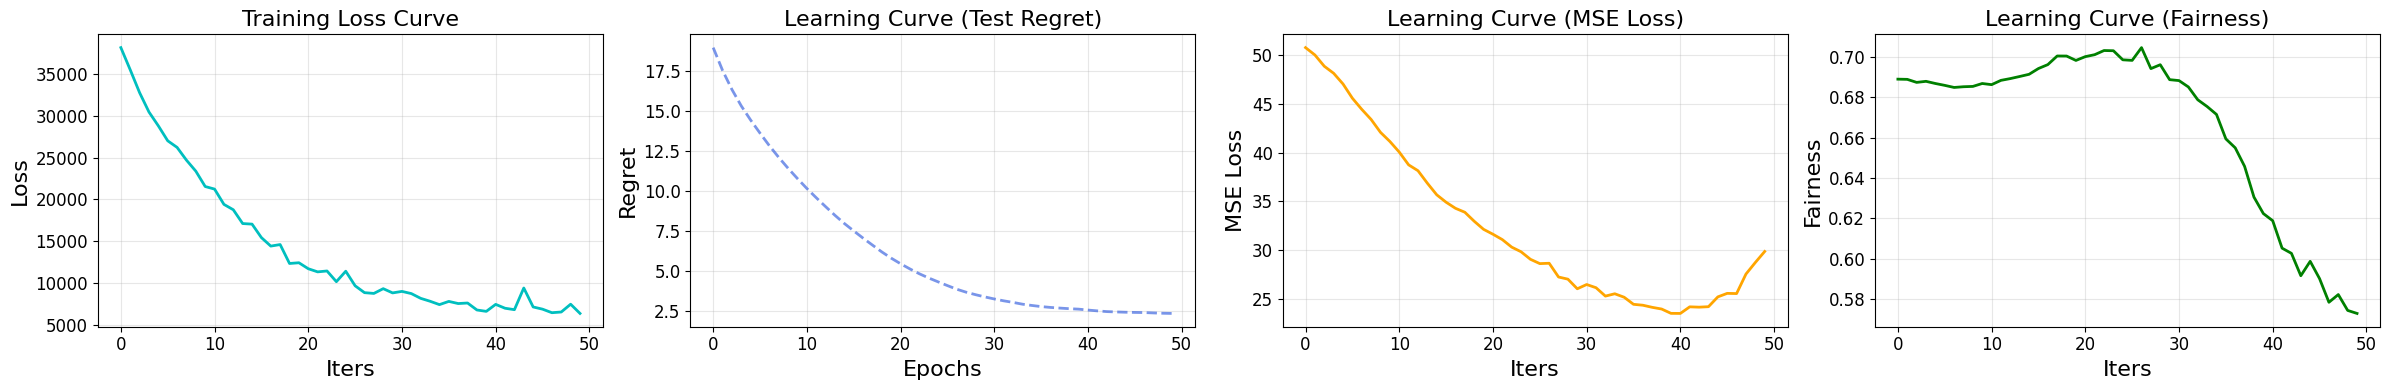

In [41]:
predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)

test_regret_log, train_loss_log, test_mse_log, test_fair_log = trainFairModel(
    predmodel=predmodel,
    optmodel=solve_closed_form,
    loader_train=dataloader_train,
    loader_test=dataloader_test,
    lambda_fairness=1,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-5,
    dfl=True,
    grad_method='closed_form',
    fairness_measure="atkinson",
)

train_loss_log_values = [loss for loss in train_loss_log]
test_regret_log_values = [regret for regret in test_regret_log]
mse_loss_log_values = [mse for mse in test_mse_log]
fairness_log_values = [fair for fair in test_fair_log]


visLearningCurve(
    train_loss_log_values,
    test_regret_log_values,
    mse_loss_log_values,
    fairness_log_values
)

Initial test regret: 20.9241
Epoch 1/50, Loss: 39037.0195, MSE: 50.7122, Fairness (accuracy_parity): 52.6112, Regret: 19.8184, LR: 0.002000
Epoch 11/50, Loss: 26432.2734, MSE: 39.0302, Fairness (accuracy_parity): 31.2932, Regret: 13.9422, LR: 0.002000
Epoch 21/50, Loss: 22447.3125, MSE: 26.0748, Fairness (accuracy_parity): 16.1177, Regret: 12.0056, LR: 0.002000
Epoch 31/50, Loss: 21410.2539, MSE: 19.7702, Fairness (accuracy_parity): 9.4966, Regret: 11.7767, LR: 0.002000
Epoch 41/50, Loss: 22069.7637, MSE: 15.4515, Fairness (accuracy_parity): 5.9232, Regret: 12.8500, LR: 0.001000
Epoch 50/50, Loss: 23296.8223, MSE: 13.2224, Fairness (accuracy_parity): 5.6980, Regret: 13.8039, LR: 0.000500


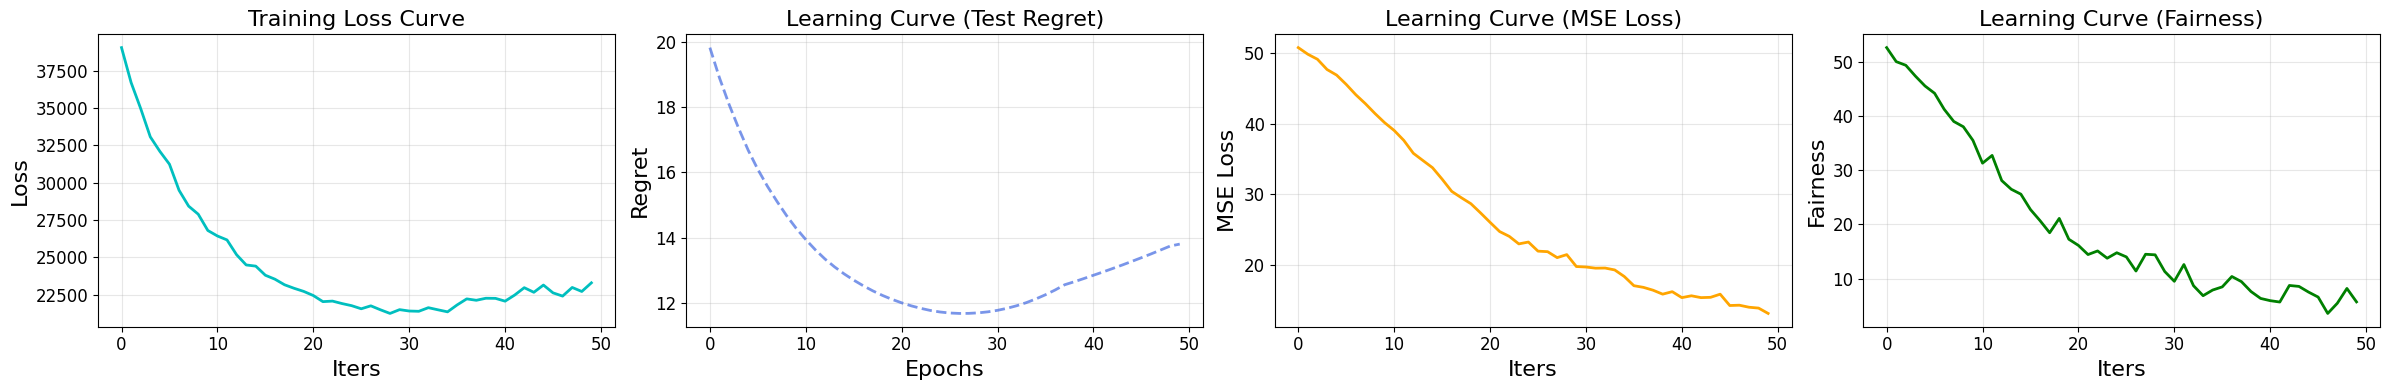

In [47]:
predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)

test_regret_log, train_loss_log, test_mse_log, test_fair_log = trainFairModel(
    predmodel=predmodel,
    optmodel=solve_closed_form,
    loader_train=dataloader_train,
    loader_test=dataloader_test,
    lambda_fairness=1,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-5,
    dfl=False,
    grad_method='closed_form',
    fairness_measure="accuracy_parity",
)

train_loss_log_values = [loss for loss in train_loss_log]
test_regret_log_values = [regret for regret in test_regret_log]
mse_loss_log_values = [mse for mse in test_mse_log]
fairness_log_values = [fair for fair in test_fair_log]
visLearningCurve(
    train_loss_log_values,
    test_regret_log_values,
    mse_loss_log_values,
    fairness_log_values
)